<a href="https://www.kaggle.com/code/andrewbaum/diamond-price-eda-and-regression?scriptVersionId=126252478" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Data Preprocessing
from sklearn.preprocessing import LabelEncoder

#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/diamonds-prices/Diamonds Prices2022.csv


# About this Notebook
This notebook uses data from "Diamonds Prices2022.csv" available on Kaggle. The data is first explored, and then various Machine Learning regression models will be run to predict the price of diamonds, followed by hyperparameter tuning.  
  
  There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.

# Loading and Inspecting the Data

In [2]:
#load the dataset from Kaggle
data = pd.read_csv("../input/diamonds-prices/Diamonds Prices2022.csv")

First we will do a few initial checks to understand the nature of the data, and determine any preprocessing steps which neeed to be taken. 

In [3]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Here we can see there's a column called 'Unnamed: 0' which is just the index. This will be removed in a later section. 

In [4]:
data.shape

(53943, 11)

In [5]:
data.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [7]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

The data is already clean and has no missing values. Therefore, only the categorical variables need to be dealt with before we can start modeling. 

In [8]:
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# Exploration of Categorical Variables

Let's look further into the categorical variables. 

In [9]:
data['cut'].value_counts()

Ideal        21551
Premium      13793
Very Good    12083
Good          4906
Fair          1610
Name: cut, dtype: int64

In [10]:
data['color'].value_counts()

G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [11]:
data['clarity'].value_counts()

SI1     13067
VS2     12259
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

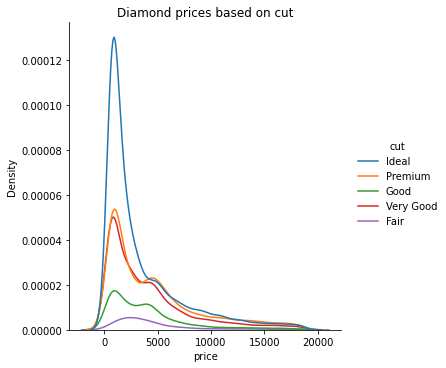

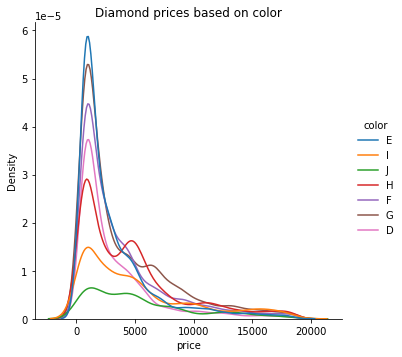

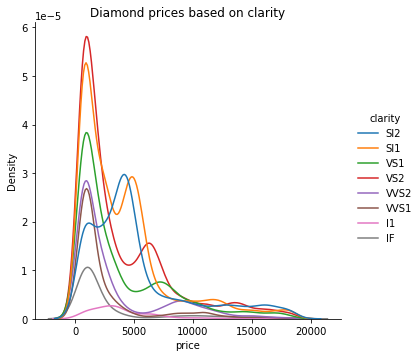

In [12]:
for c in ['cut', 'color', 'clarity']:
    sns.displot(data=data, x="price", hue=f"{c}", kind='kde')
    plt.title(f'Diamond prices based on {c.title().lower()}')
    plt.show()

# Data Cleaning

In [13]:
#Drop extra label column
data = data.drop(['Unnamed: 0'], axis=1)

In [14]:
#divide the variables into numeric and categorical
data_cat = ['cut', 'color', 'clarity']
data_num = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [15]:
data['dimensions'] = data['x'] * data['y'] * data['z']
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,dimensions
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


In [16]:
data = data[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'dimensions', 'price']]

In [17]:
data.head()

,carat,cut,color,clarity,depth,table,dimensions,price
0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,326
1,0.21,Premium,E,SI1,59.8,61.0,34.505856,326
2,0.23,Good,E,VS1,56.9,65.0,38.076885,327
3,0.29,Premium,I,VS2,62.4,58.0,46.724580,334
4,0.31,Good,J,SI2,63.3,58.0,51.917250,335


# Data Exploration

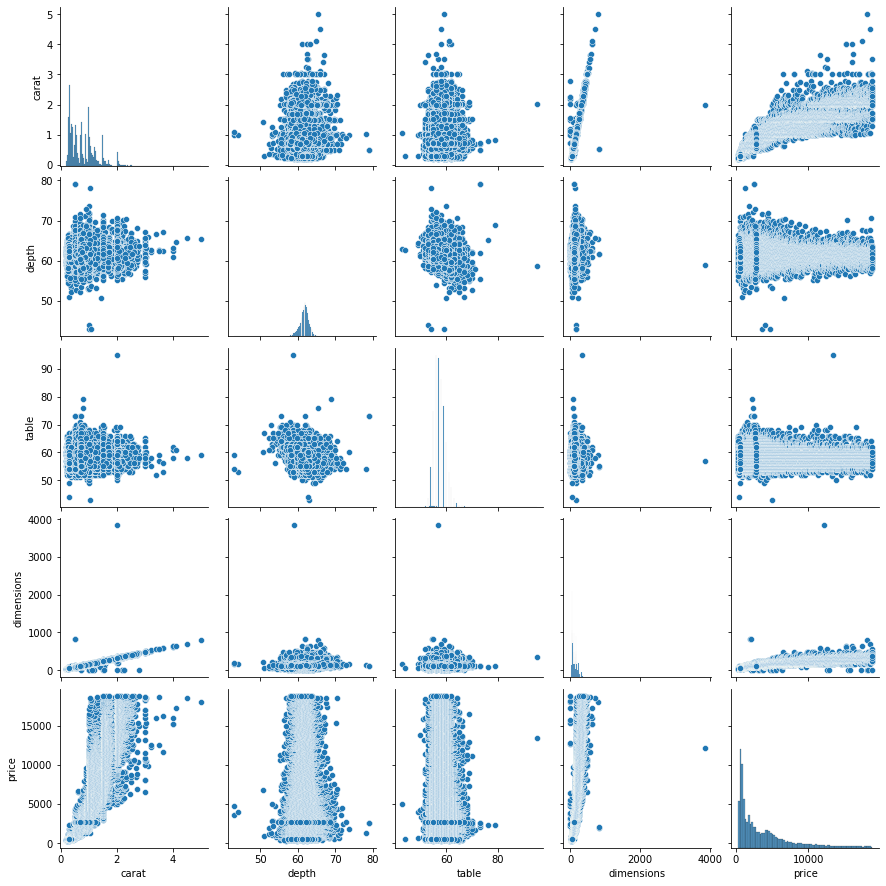

In [18]:
sns.pairplot(data)

In [19]:
corr=data.corr()
corr

,carat,depth,table,dimensions,price
carat,1.000000,0.028234,0.181602,0.976308,0.921591
depth,0.028234,1.000000,-0.295798,0.009169,-0.010630
table,0.181602,-0.295798,1.000000,0.167384,0.127118
dimensions,0.976308,0.009169,0.167384,1.000000,0.902385
price,0.921591,-0.010630,0.127118,0.902385,1.000000


<AxesSubplot:>

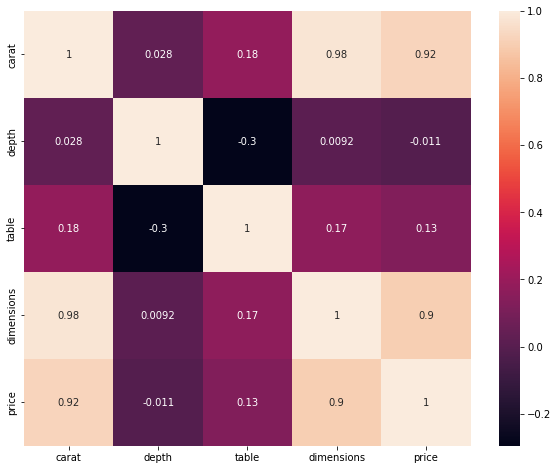

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

* There's a rather high correlation between carat and price, as well as the dimensions (x/y/z) and price

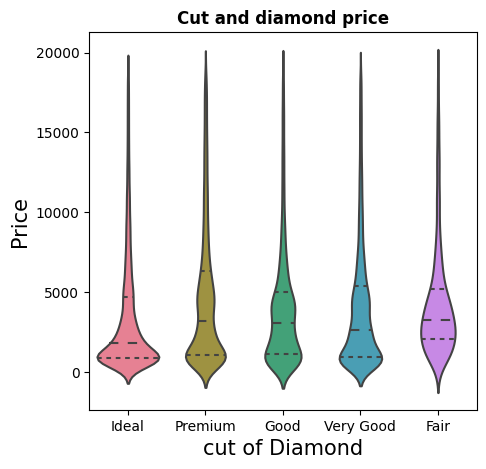

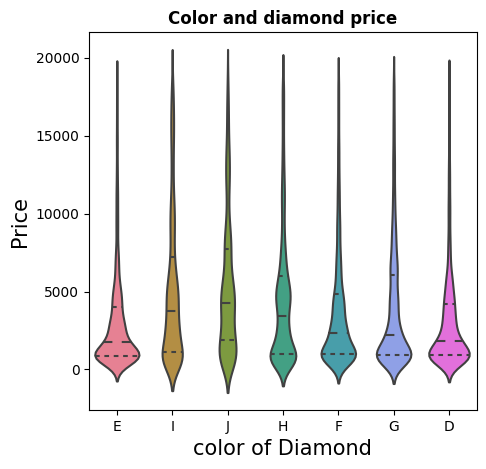

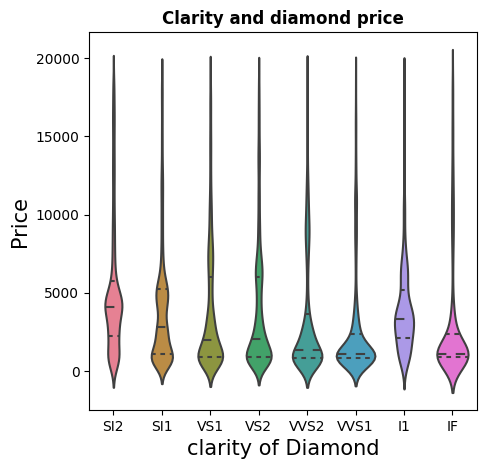

In [21]:
for c in data_cat:

    plt.figure(figsize = [5,5], dpi = 100)
    sns.violinplot(x=f'{c}', y = "price", data = data, palette = "husl", inner = "quartile")

    plt.title(f'{c.title()} and diamond price', fontdict = {"fontweight":"bold"})
    plt.xlabel(f'{c.title().lower()} of Diamond', fontdict = {"fontsize": 15})
    plt.ylabel("Price", fontdict = {"fontsize": 15})

    plt.show()

In general, diamonds have a wide price range which is dependent on multiple features. The features x, y, z, and carat have the highest correlation with price.


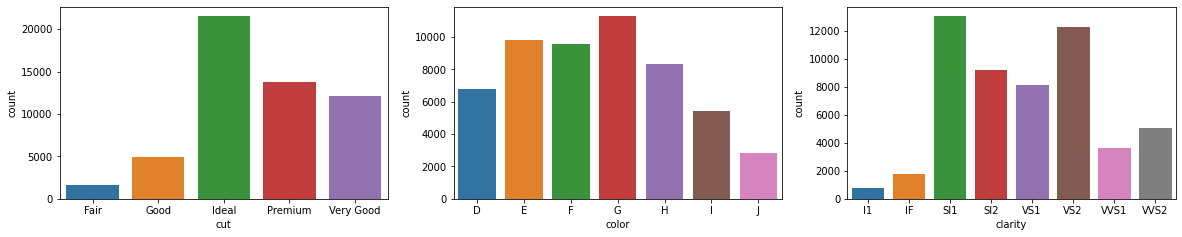

In [22]:
i = 1
plt.figure(figsize=(20, 12))
for c in data_cat:
    plt.subplot(3, 3, i)
    sns.countplot(x=data[c].sort_values())
    i+=1

The data is relatively well distributed, especially among color. There are less data points for diamonds of "fair" and "good" cuts and l1 and lF clarities, but not enough that it's likely to  be a problem during calculations. 

# Modeling

In [23]:
#encode the categorical variables
labelencoder=LabelEncoder()
data['cut'] = labelencoder.fit_transform(data['cut'])
data['color'] = labelencoder.fit_transform(data['color'])
data['clarity'] = labelencoder.fit_transform(data['clarity'])

In [24]:
data.head()

,carat,cut,color,clarity,depth,table,dimensions,price
0,0.23,2,1,3,61.5,55.0,38.202030,326
1,0.21,3,1,2,59.8,61.0,34.505856,326
2,0.23,1,1,4,56.9,65.0,38.076885,327
3,0.29,3,5,5,62.4,58.0,46.724580,334
4,0.31,1,6,3,63.3,58.0,51.917250,335


Great, now the data should be ready for modeling. 

In [25]:
#price is what we want to predict
X = data.drop(['price'],axis=1)
y=data['price']

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [27]:
X_train.head()

,carat,cut,color,clarity,depth,table,dimensions
19019,1.01,4,2,7,60.7,59.0,161.241600
2915,1.04,1,6,5,58.2,64.0,166.932920
4960,0.90,1,5,1,63.7,64.0,140.684390
28866,0.37,4,4,2,63.2,57.0,59.884416
42548,0.59,4,1,3,60.5,58.0,99.032883


In [28]:
#scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
X_test_scaled.shape

(13486, 7)

In [30]:
#function which runs different ML models and prints R^2, MAE MSE, and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    #Plotting y_test and y_pred 
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

R^2 :  0.8823571914734961
MAE : 925.213329751771
MSE : 1851711.342876913
RMSE: 1360.7760076062898


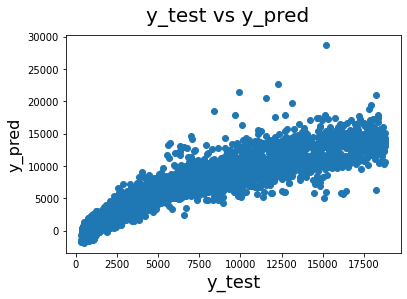

In [31]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.9648935767466393
MAE : 363.45491620940237
MSE : 552579.1415583239
RMSE: 743.3566718327911


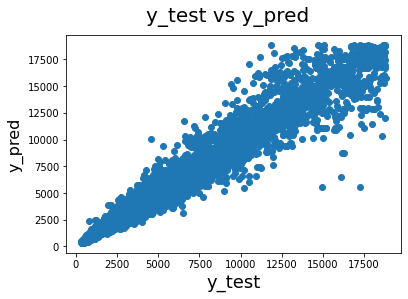

In [32]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.882360928219112
MAE : 923.3076325287424
MSE : 1851652.5260709466
RMSE: 1360.7543959403351


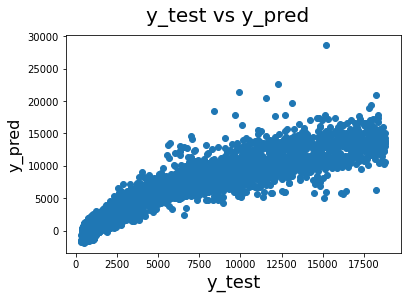

In [33]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.8676632258998619
MAE : 952.6276280680045
MSE : 2082996.0517795517
RMSE: 1443.258830487294


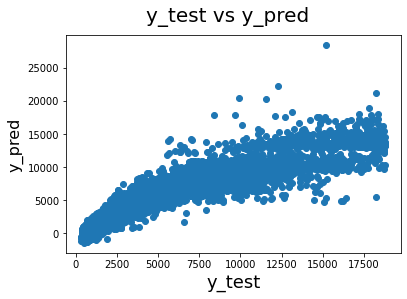

In [34]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.8822224484941514
MAE : 918.6436888968283
MSE : 1853832.2128761138
RMSE: 1361.5550715546228


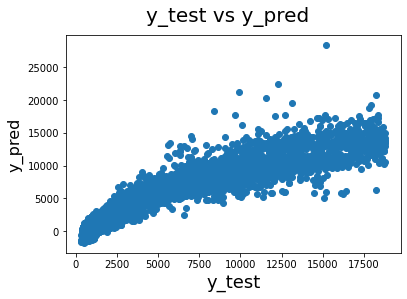

In [35]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.980172315769146
MAE : 284.11971439427776
MSE : 312090.0312829783
RMSE: 558.6501868638176


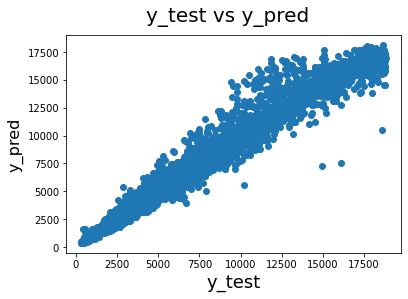

In [36]:
model_6 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_6)

RandomForest preformed better than all the other models, so a grid search will be preformed to find the optimal parameters. 

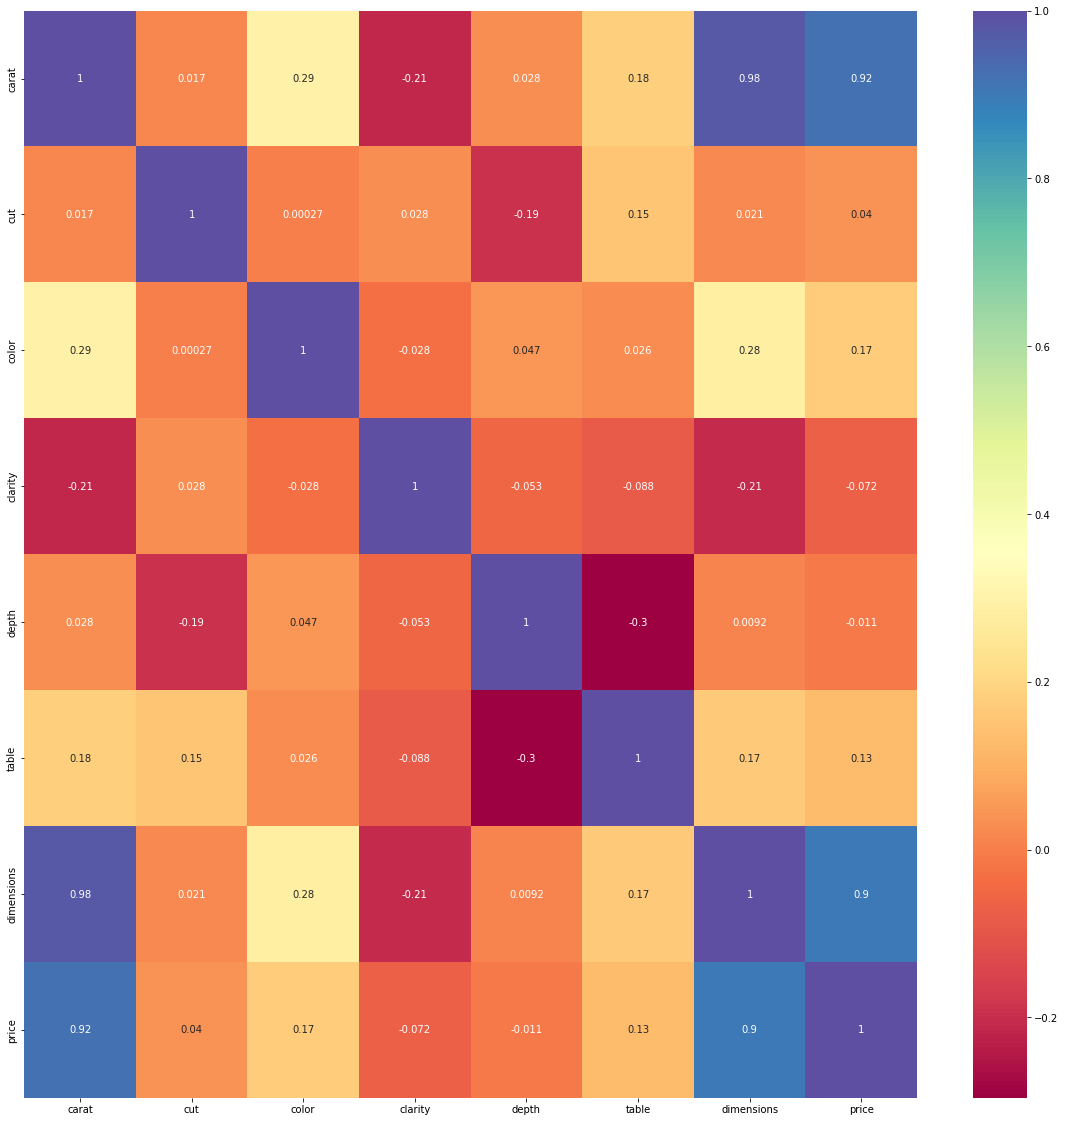

In [37]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="Spectral")

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data.drop(['price'],axis=1)
y=data['price']
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

        Specs         Score
6  dimensions  2.352730e+06
2       color  2.332561e+04
3     clarity  1.577625e+04
0       carat  1.453629e+04
1         cut  5.586035e+03
5       table  1.255650e+03
4       depth  4.453778e+02


# Hyperparameter Optimization

In [39]:
rfc=RandomForestRegressor(random_state=1)

In [40]:
#define hyperparemeters to optimize
#param_grid = { 
 #   'n_estimators': [500, 1000, 5000],
  #  'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    #'max_depth' : [10, 15, 20],
    #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
#}

In [41]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 2)
#CV_rfc.fit(X_train_scaled, y_train)

In [42]:
#print the best parameters determined in GridSearchCV
#CV_rfc.best_params_

R^2 :  0.9803690232859733
MAE : 282.30570400528995
MSE : 308993.83233379887
RMSE: 555.872136676951


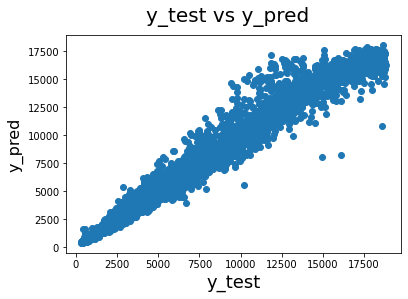

In [43]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(n_estimators=1000, max_features='auto', max_depth=15, min_samples_leaf=3, random_state=1)
run_experiment(final_model)

# Conclusions
The diamond data was cleaned up and 6 regression models were built, with RandomForest preforming the best. Hyperparameter optimization was preformed on the hyperparameters of the RandomForest model and a final model was built with the resulting optimized hyperparameters. The final RandomForest model only preformed marginally better than the inital model, however significantly better than the other models, with an R^2 of 0.980 an MAE of 282 and RMSE of 556. 